In [1]:
#函数一，获取marker邻居原子的index, 注意marker只能是一个单键连接核上的原子，否则邻居会多于一个
def get_neiid_bysymbol(mol,marker):
    try:
        for atom in mol.GetAtoms():
            if atom.GetSymbol()==marker:
                neighbors=atom.GetNeighbors()
                if len(neighbors)>1:
                    print ('Cannot process more than one neighbor, will only return one of them')
                atom_nb=neighbors[0]
                return atom_nb.GetIdx()
    except Exception as e:
        print (e)
        return None
#函数二，获取marker原子的index
def get_id_bysymbol(mol,marker):
    for atom in mol.GetAtoms():
        if atom.GetSymbol()==marker:
            return atom.GetIdx()

In [13]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

def draw_molecule_with_atom_numbers(smiles):
    """
    根据SMILES字符串绘制分子并标注原子编号。
    :param smiles: 分子的SMILES字符串
    """
    # 从SMILES字符串创建分子对象
    mol = Chem.MolFromSmiles(smiles)
    
    # 创建一个分子的拷贝，以便在不改变原始分子的情况下添加原子编号
    mol_with_atom_numbers = Chem.RWMol(mol)
    
    # 为每个原子添加原子编号作为原子标签
    for atom in mol_with_atom_numbers.GetAtoms():
        atom.SetProp('atomLabel', str(atom.GetIdx()))
    
    # 使用RDKit的绘图工具绘制分子
    img = Draw.MolToImage(mol_with_atom_numbers, size=(300, 300))
    
    # 显示图像
    display(img)

In [2]:
def combine2frags(mol_a,mol_b,maker_b='Cs',maker_a='Fr'):
    #将两个待连接分子置于同一个对象中
    merged_mol = Chem.CombineMols(mol_a,mol_b)
    bind_pos_a=get_neiid_bysymbol(merged_mol,maker_a)
    bind_pos_b=get_neiid_bysymbol(merged_mol,maker_b)
    #转换成可编辑分子，在两个待连接位点之间加入单键连接，特殊情形需要其他键类型的情况较少，需要时再修改
    ed_merged_mol= Chem.EditableMol(merged_mol)
    ed_merged_mol.AddBond(bind_pos_a,bind_pos_b,order=Chem.rdchem.BondType.SINGLE)
    #将图中多余的marker原子逐个移除，先移除marker a
    marker_a_idx=get_id_bysymbol(merged_mol,maker_a)
    ed_merged_mol.RemoveAtom(marker_a_idx)
    #marker a移除后原子序号变化了，所以又转换为普通分子后再次编辑，移除marker b
    temp_mol = ed_merged_mol.GetMol()
    marker_b_idx=get_id_bysymbol(temp_mol,maker_b)
    ed_merged_mol=Chem.EditableMol(temp_mol)
    ed_merged_mol.RemoveAtom(marker_b_idx)
    final_mol = ed_merged_mol.GetMol()
    return final_mol

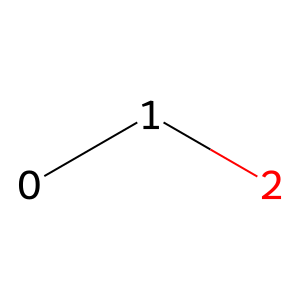

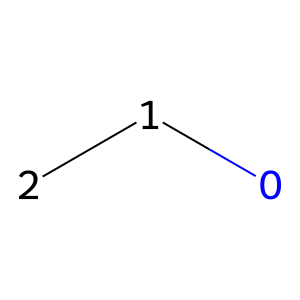

New SMILES: <rdkit.Chem.rdchem.Mol object at 0x7f0c0042ef80>
New Atom Indexes: 4 0


In [23]:
from rdkit import Chem
from rdkit.Chem import rdchem

def connect_molecules(smiles1, smiles2, atom_index1, atom_index2):
    # 从SMILES加载两个分子
    mol_a = Chem.MolFromSmiles(smiles1)
    mol_b = Chem.MolFromSmiles(smiles2)

    # 将两个待连接分子置于同一个对象中
    merged_mol = Chem.CombineMols(mol_a, mol_b)
    ed_merged_mol = Chem.EditableMol(merged_mol)
    
    # 计算合并后分子中原子b的实际索引
    num_atoms_a = mol_a.GetNumAtoms()
    atom_index1 += num_atoms_a  # 更新b的位置，因为它现在是合并分子的一部分
    
    # 在两个待连接位点之间加入单键连接
    ed_merged_mol.AddBond(atom_index1, atom_index2, order=rdchem.BondType.SINGLE)

    # 返回新分子的SMILES和连接点索引
    return ed_merged_mol.GetMol(), atom_index1, atom_index2

# 示例用法
smiles1 = 'CCO'  # 乙醇
smiles2 = 'NCC'  # 乙胺
atom_index1 = 1  # 乙醇的氧原子
atom_index2 = 0  # 乙胺的氮原子

draw_molecule_with_atom_numbers(smiles1)
draw_molecule_with_atom_numbers(smiles2)
new_smiles, new_index1, new_index2 = connect_molecules(smiles1, smiles2, atom_index1, atom_index2)
print("New SMILES:", new_smiles)
print("New Atom Indexes:", new_index1, new_index2)

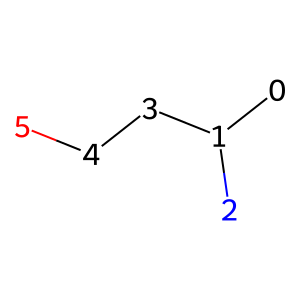

In [22]:
draw_molecule_with_atom_numbers(Chem.MolToSmiles(new_smiles))

In [3]:
from rdkit import Chem
from rdkit.Chem import rdchem

def find_unsaturated_atoms(mol):
    """
    Find unsaturated atoms in a molecule
    """
    unsaturated_atoms = []
    for atom in mol.GetAtoms():
        if atom.GetImplicitValence() > 0 or not atom.IsInRing():
            unsaturated_atoms.append(atom.GetIdx())
    return unsaturated_atoms

def find_unique_unsaturated_atoms(mol):
    """
    Find unique unsaturated atoms in a molecule, considering both the unsaturation of atoms and the symmetry of the molecule
    """
    unsaturated_atoms = []
    for atom in mol.GetAtoms():
        if atom.GetImplicitValence() > 0:  # or not atom.IsInRing()
            unsaturated_atoms.append(atom.GetIdx())
    
    symm_info = Chem.rdmolops.GetSymmSSSR(mol)
    unique_atoms = set(unsaturated_atoms)

    for symm_set in symm_info:
        symm_atoms_in_set = [idx for idx in symm_set if idx in unsaturated_atoms]
        if len(symm_atoms_in_set) > 1:
            for atom_idx in symm_atoms_in_set[1:]:
                if atom_idx in unique_atoms:
                    unique_atoms.remove(atom_idx)

    return list(unique_atoms)

def combine_molecules(mol_a, mol_b):
    """
    自动寻找两个分子中可以成键的位点并组合这两个分子
    """
    # 寻找每个分子中的未饱和原子
    # unsaturated_a = find_unsaturated_atoms(mol_a)
    # unsaturated_b = find_unsaturated_atoms(mol_b)
    
    # find unique unsaturated atoms
    unsaturated_a = find_unique_unsaturated_atoms(mol_a)
    unsaturated_b = find_unique_unsaturated_atoms(mol_b)
    
    # All mols
    mols_list = []
    
    # Make sure both lists are not empty
    if unsaturated_a and unsaturated_b:
        
        for i in range(len(unsaturated_a)):
            for j in range(len(unsaturated_b)):
                
                bind_pos_a = unsaturated_a[i]
                bind_pos_b = unsaturated_b[j]
                
                # 将两个待连接分子置于同一个对象中
                merged_mol = Chem.CombineMols(mol_a, mol_b)
                ed_merged_mol = Chem.EditableMol(merged_mol)
                
                # 计算合并后分子中原子b的实际索引
                num_atoms_a = mol_a.GetNumAtoms()
                bind_pos_b += num_atoms_a  # 更新b的位置，因为它现在是合并分子的一部分
                
                # 在两个待连接位点之间加入单键连接
                ed_merged_mol.AddBond(bind_pos_a, bind_pos_b, order=rdchem.BondType.SINGLE)
                
                final_mol = ed_merged_mol.GetMol()
                mols_list.append(final_mol)
                
        return mols_list
    
    else:
        print("No suitable unsaturated atoms found for bonding.")
        return None

In [4]:
mol = Chem.MolFromSmiles('n1ccccc1')
unsaturated_atoms = []
for atom in mol.GetAtoms():
    if atom.GetImplicitValence() > 0:
        unsaturated_atoms.append(atom.GetIdx())

symm_info = Chem.rdmolops.GetSymmSSSR(mol)
unique_atoms = set(unsaturated_atoms)  # 应该操作这个集合来保留唯一原子

for symm_set in symm_info:
    symm_atoms_in_set = [idx for idx in symm_set if idx in unsaturated_atoms]
    if len(symm_atoms_in_set) > 1:
        for atom_idx in symm_atoms_in_set[1:]:
            if atom_idx in unique_atoms:  # 正确地移除非唯一的原子
                unique_atoms.remove(atom_idx)

In [5]:
# 获取原子的规范等级
ranks = Chem.rdmolfiles.CanonicalRankAtoms(mol)
unsaturated_atoms = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetImplicitValence() > 0]

# 通过规范等级来识别对称等价的原子
rank_to_atom = {}
for atom_idx in unsaturated_atoms:
    rank = ranks[atom_idx]
    if rank not in rank_to_atom:
        rank_to_atom[rank] = atom_idx

# 从每个对称等价组中选择一个原子作为唯一的成键位点
unique_atoms = list(rank_to_atom.values())

In [6]:
import pandas as pd
df = pd.read_csv("./fragments.csv")

all_mols = df["SMILES"].to_list()
all_mols = [Chem.MolFromSmiles(smiles) for smiles in all_mols]

[03:27:33] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[03:27:33] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8


In [7]:
connected_mols = []

for i in range(len(all_mols)):
    for j in range(i+1, len(all_mols)):
        try:
            mols_list = combine_molecules(all_mols[i], all_mols[j])
        except:
            continue
    
        if mols_list:
            connected_mols.extend(mols_list)

In [9]:
from rdkit.Chem import AllChem
for m in connected_mols: tmp=AllChem.Compute2DCoords(m)

for m in connected_mols:
    try:
        Chem.Draw.MolToImage(m)
    except:
        connected_mols.remove(m)
        
img = Chem.Draw.MolsToGridImage(connected_mols[:8], molsPerRow=4, subImgSize=(200, 200), legends=None)

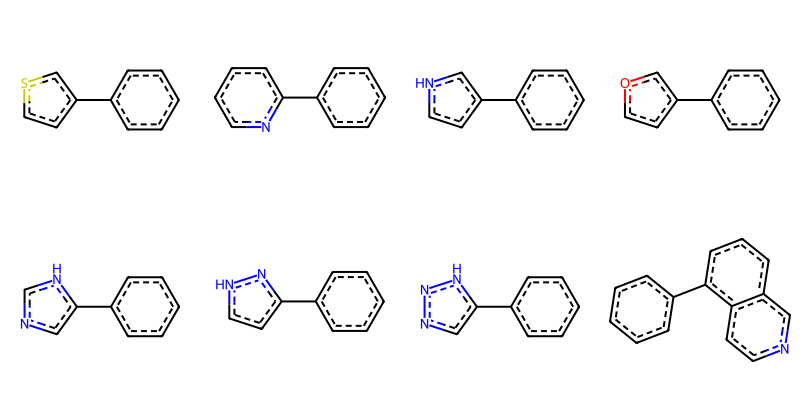

In [13]:
img

In [12]:
from matplotlib import pyplot as plt
plt.show()